# Titanic (lightGBM classifier)
* Notebook: https://github.com/prasertcbs/scikitlearn_tutorial/blob/main/notebook/titanic_lightgbm.ipynb
* kaggle: https://www.kaggle.com/c/titanic
* lightgbm: https://lightgbm.readthedocs.io/en/latest/

[<img src="https://github.com/microsoft/LightGBM/raw/master/docs/logo/LightGBM_logo_black_text_small.png">](https://lightgbm.readthedocs.io/en/latest/)

---
* author:  [Prasert Kanawattanachai](prasert.k@chula.ac.th)
* YouTube: https://www.youtube.com/prasertcbs
* github: https://github.com/prasertcbs/
* [Chulalongkorn Business School](https://www.cbs.chula.ac.th/en/)
---

In [1]:
import math
from pprint import pprint
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
print(f'pandas  version: {pd.__version__}')
print(f'numpy   version: {np.__version__}')
print(f'seaborn version: {sns.__version__}')

pandas  version: 1.2.3
numpy   version: 1.19.2
seaborn version: 0.11.1


## utility functions

In [4]:
def df_unique_value(df):
    for c in df.columns:
        col_type = df[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            print(f'{c:10}\n{df[c].unique()}')
            print('-' * 65)
            
def convert_cols_to_category(df, cols:list):
    """
    convert `cols` to `category`
    """
    for c in df[cols]:
        df[c] = df[c].astype('category')
    return df
    
def convert_obj_columns_to_category(df):
    for c in df.columns:
        col_type = df[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            df[c] = df[c].astype('category')
    return df

def print_category_columns(df):
    for c in df.columns:
        col_type = df[c].dtype
        if col_type.name == 'category':
    #         print(f'{c}: {df[c].cat.categories}')
    #         print(pd.Series(df[c].cat.categories))
            print(f'{c:15}: {list(enumerate(df[c].cat.categories))}')
            print('-' * 60)
            
def plot_mn(df, cols, n_rows:int=1, kind:str='boxplot', color='salmon'):
    """
    plot boxplot, violin, hist in m (rows) by n (columns)
    >>> plot_mn(df, ['Calories', 'Fat'], 2, 'hist')
    """
    n=len(cols)
    n_cols=math.ceil(n / n_rows)
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*4))
    ax=ax.ravel()

    fig.tight_layout()
    for i, c in enumerate(cols):
        col_type = df[c].dtype
        if col_type.name == 'category':
            sns.countplot(data=df, x=c, ax=ax[i])
        else:
            if kind.lower()=='boxplot':
                sns.boxplot(data=df[[c]], ax=ax[i], color=color)   
            elif kind.lower()=='violin':
                sns.violinplot(data=df[[c]], ax=ax[i], color=color)   
            elif kind.lower()=='hist':
                sns.distplot(df[c], hist=True, kde=False, ax=ax[i], color=color)  


## data
| Variable | Definition                                                             | Key                                            |
|----------|------------------------------------------------------------------------|------------------------------------------------|
| Survived | Survival                                                               | 0 = No, 1 = Yes                                |
| Pclass   | Ticket class                                                           | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex      | Sex                                                                    |                                                |
| Age      | Age in years                                                           |                                                |
| SibSp    | # of siblings / spouses aboard the Titanic                             |                                                |
|          | Sibling = brother, sister, stepbrother, stepsister                     |                                                |
|          | Spouse = husband, wife (mistresses and fiancés were ignored)           |                                                |
| Parch    | # of parents / children aboard the Titanic                             |                                                |
|          | Parent = mother, father                                                |                                                |
|          | Child = daughter, son, stepdaughter, stepson                           |                                                |
|          | Some children travelled only with a nanny, therefore parch=0 for them. |                                                |
| Ticket   | Ticket number                                                          |                                                |
| Fare     | Passenger fare                                                         |                                                |
| Cabin    | Cabin number                                                           |                                                |
| Embarked | Port of Embarkation                                                    | C = Cherbourg, Q = Queenstown, S = Southampton |

In [5]:
df=pd.read_csv('https://github.com/prasertcbs/basic-dataset/raw/master/titanic_train.csv')
df.sample(n=10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
655,656,0,2,"Hickman, Mr. Leonard Mark",male,24.0,2,0,S.O.C. 14879,73.5000,NaN,S
598,599,0,3,"Boulos, Mr. Hanna",male,NaN,0,0,2664,7.2250,NaN,C
662,663,0,1,"Colley, Mr. Edward Pomeroy",male,47.0,0,0,5727,25.5875,E58,S
671,672,0,1,"Davidson, Mr. Thornton",male,31.0,1,0,F.C. 12750,52.0000,B71,S
144,145,0,2,"Andrew, Mr. Edgardo Samuel",male,18.0,0,0,231945,11.5000,NaN,S
763,764,1,1,"Carter, Mrs. William Ernest (Lucile Polk)",female,36.0,1,2,113760,120.0000,B96 B98,S
345,346,1,2,"Brown, Miss. Amelia ""Mildred""",female,24.0,0,0,248733,13.0000,F33,S
79,80,1,3,"Dowdell, Miss. Elizabeth",female,30.0,0,0,364516,12.4750,NaN,S
90,91,0,3,"Christmann, Mr. Emil",male,29.0,0,0,343276,8.0500,NaN,S
371,372,0,3,"Wiklund, Mr. Jakob Alfred",male,18.0,1,0,3101267,6.4958,NaN,S


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### convert obj/string columns to category data type for lightGBM

In [7]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [8]:
cols_to_cat=['Pclass', 'Sex', 'Embarked']

convert_cols_to_category(df, cols_to_cat)
print_category_columns(df)

Pclass         : [(0, 1), (1, 2), (2, 3)]
------------------------------------------------------------
Sex            : [(0, 'female'), (1, 'male')]
------------------------------------------------------------
Embarked       : [(0, 'C'), (1, 'Q'), (2, 'S')]
------------------------------------------------------------


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    category
 3   Name         891 non-null    object  
 4   Sex          891 non-null    category
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    object  
 11  Embarked     889 non-null    category
dtypes: category(3), float64(2), int64(4), object(3)
memory usage: 65.8+ KB


In [10]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

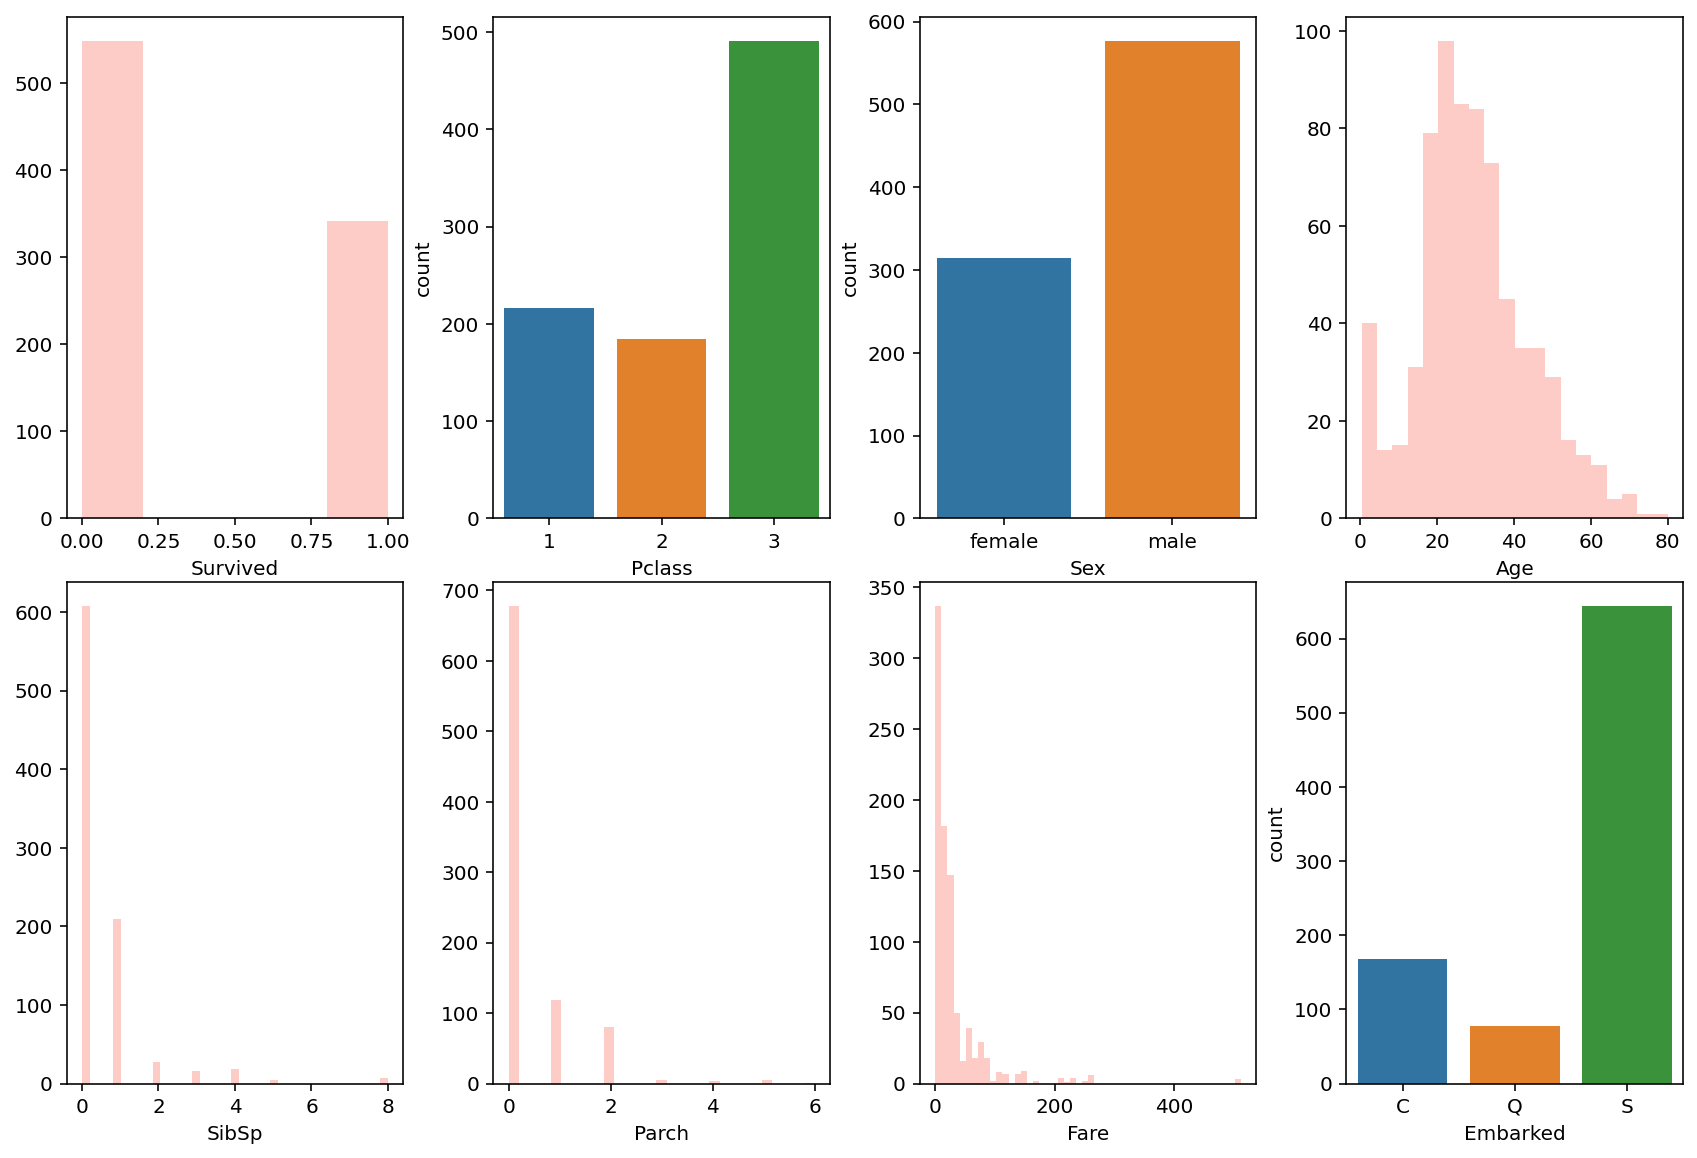

In [11]:
cols=['Survived', 'Pclass', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked']
plot_mn(df, cols, 2, 'hist')

## lightgbm
* `lightGBM` doc: https://lightgbm.readthedocs.io/en/latest/
* `LGBMClassifier`: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier


how to install lightgbm
* pip: `pip install -U lightgbm`
* conda: `conda install lightgbm`

In [12]:
import lightgbm as lgb
print(f'lightgbm version {lgb.__version__}')

lightgbm version 3.1.1


In [13]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, ShuffleSplit, cross_val_score, cross_val_predict, cross_validate
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, precision_recall_fscore_support, f1_score

In [14]:
df[:5]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [15]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [16]:
feature_cols=['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']
target_col='Survived'

X=df[feature_cols]
y=df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=1, 
                                                    stratify=y)

In [17]:
y_train.value_counts()

0    439
1    273
Name: Survived, dtype: int64

In [18]:
clf=lgb.LGBMClassifier()

In [19]:
clf.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [20]:
# tuning parameters: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
# https://sites.google.com/view/lauraepp/parameters
params={'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

# clf = lgb.LGBMClassifier(**params)

In [21]:
# eval_metric: https://lightgbm.readthedocs.io/en/latest/Parameters.html?highlight=metric#metric-parameters
fit_params={'early_stopping_rounds':100, 
            'eval_metric': 'auc', # [binary_logloss, auc]
            'eval_set': [(X_test, y_test)],
            'verbose': 10
           }

clf.fit(X_train, y_train, **fit_params)

Training until validation scores don't improve for 100 rounds
[10]	valid_0's auc: 0.861001	valid_0's binary_logloss: 0.462338
[20]	valid_0's auc: 0.86996	valid_0's binary_logloss: 0.419414
[30]	valid_0's auc: 0.868709	valid_0's binary_logloss: 0.409488
[40]	valid_0's auc: 0.869829	valid_0's binary_logloss: 0.410124
[50]	valid_0's auc: 0.866601	valid_0's binary_logloss: 0.415623
[60]	valid_0's auc: 0.863175	valid_0's binary_logloss: 0.421308
[70]	valid_0's auc: 0.855995	valid_0's binary_logloss: 0.425925
[80]	valid_0's auc: 0.855731	valid_0's binary_logloss: 0.429418
[90]	valid_0's auc: 0.854677	valid_0's binary_logloss: 0.434468
[100]	valid_0's auc: 0.854414	valid_0's binary_logloss: 0.436328
Did not meet early stopping. Best iteration is:
[35]	valid_0's auc: 0.874111	valid_0's binary_logloss: 0.407121


LGBMClassifier()

In [22]:
clf.__dict__

{'boosting_type': 'gbdt',
 'objective': None,
 'num_leaves': 31,
 'max_depth': -1,
 'learning_rate': 0.1,
 'n_estimators': 100,
 'subsample_for_bin': 200000,
 'min_split_gain': 0.0,
 'min_child_weight': 0.001,
 'min_child_samples': 20,
 'subsample': 1.0,
 'subsample_freq': 0,
 'colsample_bytree': 1.0,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'random_state': None,
 'n_jobs': -1,
 'silent': True,
 'importance_type': 'split',
 '_Booster': <lightgbm.basic.Booster at 0x27d9b7765c8>,
 '_evals_result': {'valid_0': OrderedDict([('auc',
                [0.8640316205533597,
                 0.8654150197628458,
                 0.8624505928853755,
                 0.8602766798418973,
                 0.8601449275362318,
                 0.8635046113306983,
                 0.8617918313570487,
                 0.8586297760210804,
                 0.8600790513833992,
                 0.8610013175230566,
                 0.8648221343873518,
                 0.8668642951251647,
                 0.8694

In [ ]:
lgb.plot_metric(clf, metric='binary_logloss')

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

In [ ]:
lgb.plot_metric(clf, metric='auc')

In [ ]:
clf.score(X_train, y_train) # classification accuracy score

In [ ]:
clf.score(X_test, y_test) # classification accuracy score

In [ ]:
clf.predict(X_test)[:20]

In [ ]:
clf.predict_proba(X_test)[:20]

### confusion matrix
$$
\begin{bmatrix}
C_{0,0} & C_{0,1} \\
C_{1,0} & C_{1,1}
\end{bmatrix}
=
\begin{bmatrix}
tn&fp \\
fn&tp
\end{bmatrix}
$$

<table>
<tr>
    <td></td>
    <td>predicted false</td>
    <td>predicted true</td>
</tr>
<tr>
    <td>actual false</td>
    <td>tn</td>
    <td>fp</td>
</tr>
<tr>
    <td>actual true</td>
    <td>fn</td>
    <td>tp</td>
</tr>
<table>

In [ ]:
cm=confusion_matrix(y_test, clf.predict(X_test))
cm

In [ ]:
plt.rcParams['font.size']=13
plot_confusion_matrix(clf, X_test, y_test, cmap='Oranges', display_labels=['dead', 'survived'])

$$
\begin{align}
\text {Accuracy}&={\frac {{TP+TN} }{TP + TN +FP + FN} }\\
\text {Precision}&={\frac {TP}{TP+FP}}\\
\text {Recall, True Positive Rate (TPR), sensitivity}&={\frac {TP}{TP+FN}}\\
\text {False Positive Rate (FPR), miss rate}&={\frac {FP}{FP+TN}}\\
F1&=2 \times {\frac {precision \times recall} {precision + recall}}\\
\end{align}
$$

$$
\begin{align}
Recall_0&={\frac {TN}{TN+FP}}\\
Recall_1&={\frac {TP}{TP+FN}}\\
Precision_0&={\frac {TN}{TN+FN}}\\
Precision_1&={\frac {TP}{TP+FP}}\\
\end{align}
$$

In [ ]:
print(classification_report(y_train, clf.predict(X_train)))

In [ ]:
print(classification_report(y_test, clf.predict(X_test)))

In [ ]:
# explore threshold
def precision(cfm):
    '''
    precision
    '''
    tn, fp, fn, tp = cfm.ravel()
    return tp / (tp + fp)

def tpr(cfm):
    '''
    true positive rate (recall)
    '''
    tn, fp, fn, tp = cfm.ravel()
    return tp / (tp + fn)

def fpr(cfm):
    '''
    false positive rate'''
    tn, fp, fn, tp = cfm.ravel()
    return fp / (fp + tn)

def cm(model, X, y, thres=.5):
    '''
    confusion matrix at a given threshold
    '''
    y_pred_tmp=np.where(model.predict_proba(X)[:, 1] >= thres, 1, 0)
    return confusion_matrix(y, y_pred_tmp)

def varying_threshold(model, X, y, thresholds=np.linspace(0.05, .95, 15)):
    for thres in thresholds:
        cfm=cm(model, X, y, thres)
        print(f'threshold={thres:.2f}, TPR = {tpr(cfm):.2f}, FPR = {fpr(cfm):.2f}, precision = {precision(cfm):.2f}');    
        print(cfm)
        print('-' * 100)
        
varying_threshold(clf, X_test, y_test)

### cross validation

In [ ]:
scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print(scores)
print(f'mean scores = {scores.mean()}, sd={scores.std():.4f}')                                              

### feature importances

In [ ]:
clf.feature_importances_

In [ ]:
X.columns

In [ ]:
feature_importances=pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importances

In [ ]:
pd.DataFrame(feature_importances).style.background_gradient(cmap="Oranges")

In [ ]:
lgb.plot_importance(clf, figsize=(10, 7), height=.5)

### tree diagram
* **install graphviz on Windows**
1. install graphviz: `pip install -U graphviz`
1. download graphviz: https://www2.graphviz.org/Packages/stable/windows/10/msbuild/Release/Win32/
1. extract and copy to: `C:\Program Files (x86)\Graphviz\bin`
1. add `C:\Program Files (x86)\Graphviz\bin` to `PATH` enviroment variable

In [ ]:
print_category_columns(df)

In [ ]:
lgb.create_tree_digraph(clf, orientation='vertical')

In [ ]:
# show_info=['split_gain', 'leaf_count', 'leaf_weight', 'internal_value', 'data_percentage']
show_info=['leaf_weight', 'internal_value', 'data_percentage']
orientation='horizontal'

In [ ]:
lgb.create_tree_digraph(clf, orientation=orientation, show_info=show_info)

In [ ]:
lgb.create_tree_digraph(clf, orientation=orientation, tree_index=0, show_info=show_info)

In [ ]:
lgb.create_tree_digraph(clf, orientation=orientation, tree_index=1, show_info=show_info)

In [ ]:
lgb.create_tree_digraph(clf, orientation=orientation, tree_index=2, show_info=show_info)

In [ ]:
lgb.create_tree_digraph(clf, orientation=orientation, tree_index=3, show_info=show_info)

In [ ]:
lgb.create_tree_digraph(clf, orientation=orientation, tree_index=4, show_info=show_info)

In [ ]:
lgb.create_tree_digraph(clf, orientation=orientation, tree_index=5, show_info=show_info)

In [ ]:
lgb.create_tree_digraph(clf, orientation=orientation, tree_index=6, show_info=show_info)

In [ ]:
lgb.create_tree_digraph(clf, orientation=orientation, tree_index=7, show_info=show_info)

In [ ]:
lgb.create_tree_digraph(clf, orientation=orientation, tree_index=8, show_info=show_info)

In [ ]:
lgb.create_tree_digraph(clf, orientation=orientation, tree_index=34, show_info=show_info)

In [ ]:
g=lgb.create_tree_digraph(clf, orientation='vertical')

# g.format='svg'
# g.format='png'
# g.format='pdf'
# g.render('tree.gv', view=True)

## SHAP

In [ ]:
import shap

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

$$
\begin{align}
\text{odds}&=\frac{p}{1-p} \\ \\
\text{log odds or logit} (\textbf{logi}\text{stic un}\textbf{it})&=ln(\frac{p}{1-p}) \\ \\
p&=\frac{odds}{1+odds}
\end{align}
$$

$$
\begin{align}
logit&=ln(\frac{p}{1-p}) \\ \\
\text{how to inverse } logit \\ \\
ln(\frac{p}{1-p})&=ln(odds) \\ \\
\frac{p}{1-p}&=e^{ln(odds)} \\ \\
p&=(1-p)e^{ln(odds)} \\ \\
p&=e^{ln(odds)}-p\cdot e^{ln(odds)} \\ \\
p+p\cdot e^{ln(odds)}&=e^{ln(odds)} \\ \\
p(1+e^{ln(odds)})&=e^{ln(odds)} \\ \\
p&=\frac{e^{ln(odds)}}{1+e^{ln(odds)}} \\ \\
p&=\frac{1}{1+e^{-ln(odds)}} \\ \\
\end{align}
$$

In [ ]:
p=np.arange(0, 1, .01)
y=np.log(p/(1-p))

plt.plot(p, y)
plt.grid(True)
plt.axvline(.5, color='red')
plt.ylabel('ln(odds) or logit')

In [ ]:
x=np.arange(-10, 10, .5)
y=1/(1+np.exp(-x))

plt.plot(x, y)
plt.grid(True)
plt.axhline(.5, color='red')
plt.ylabel('prob')

In [ ]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def log_odds_to_prob(x):
    return 1-1/(1+np.exp(x))

def logit_to_prob(logit):
    odds=np.exp(logit)
    return odds / (1 + odds)

def odds(p):
    return p/(1-p)

def case_detail(case_data):
    '''
    format obj returned from shap.force_plot()
    '''
    de=pd.DataFrame(case_data.data['features'])
    fcols=[]
    for i in case_data.data['features'].keys():
        fcols.append(case_data.data['featureNames'][i])
    de.columns=fcols
    return de

def individual_case_plot(explainer, X, case_index, class_no=1, link='logit', verbose=False):
    """
    >>> individual_case_plot(explainer, X_train, 1)
    """
#     link='identity' # show value as log-odds
#     link='logit' # show value as prob
    shap_values = explainer.shap_values(X.iloc[[case_index]])[class_no]
    g=shap.force_plot(explainer.expected_value[class_no], shap_values=shap_values, features=X.iloc[case_index, :], link=link)
    if verbose:
        print(f'predict_proba = {clf.predict_proba(X.iloc[[case_index]])}')
        p=logit_to_prob(g.data['outValue'])
        print(f'p={p:.4f}, odds={odds(p):.2f}')
        pprint(g.__dict__)
    return g

In [ ]:
len(shap_values)

In [ ]:
shap_values[1].shape

In [ ]:
shap_values[0] # class = 0 (dead)

In [ ]:
shap_values[1] # class = 1 (survived)

In [ ]:
dshap=pd.DataFrame(shap_values[1], columns=feature_cols)
dshap

### feature importances

In [ ]:
np.abs(dshap).mean().sort_values(ascending=False)

In [ ]:
shap.summary_plot(shap_values[1], X, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values[1], X)

### dependence_plot

In [ ]:
X.info()

In [ ]:
class_no=1

In [ ]:
shap.dependence_plot('Pclass', shap_values=shap_values[class_no], features=X, interaction_index='Sex')    

In [ ]:
shap.dependence_plot('Sex', shap_values=shap_values[class_no], features=X, interaction_index='Pclass')    

In [ ]:
shap.dependence_plot('Pclass', shap_values=shap_values[class_no], features=X, interaction_index='Age')    

In [ ]:
shap.dependence_plot('Age', shap_values=shap_values[class_no], features=X, interaction_index='Pclass')    

In [ ]:
class_no=1
for c in feature_cols:
    shap.dependence_plot(c, shap_values=shap_values[class_no], features=X)    

### interpret case(s)

In [ ]:
shap_values[1][:5]

In [ ]:
X[:5]

In [ ]:
case_index=0
X.iloc[[case_index]]

In [ ]:
explainer.shap_values(X.iloc[[case_index]])[1]

In [ ]:
clf.predict_proba(X[:5])

In [ ]:
clf.predict(X[:5])

In [ ]:
g=individual_case_plot(explainer, X, case_index=0, class_no=1, link='identity') # link='identity' will show log odds value
g

In [ ]:
g.__dict__

In [ ]:
g=individual_case_plot(explainer, X, case_index=0, class_no=1, link='logit') # link='logit' will change log-odds number into probability
g

In [ ]:
g=individual_case_plot(explainer, X, case_index=0, class_no=1, link='logit', verbose=True) # link='logit' will change log-odds number into probability
g

In [ ]:
logit_to_prob(explainer.expected_value[1]) # base value

In [ ]:
p=logit_to_prob(g.data['outValue'])
print(f'p={p:.2f}, odds={odds(p):.2f}')

In [ ]:
clf.predict_proba(X.iloc[[0]])

In [ ]:
case_index=1
g=individual_case_plot(explainer, X, case_index=case_index, class_no=1, link='logit', verbose=True)
g

In [ ]:
case_detail(g)

In [ ]:
g=individual_case_plot(explainer, X, case_index=2, class_no=1, link='logit', verbose=True)
g

In [ ]:
class_no=1
shap.force_plot(explainer.expected_value[class_no], shap_values[class_no][:100], X[:100])